# 13 - Prueba de Concepto: Tendencias Políticas en Twitter


* Vamos a realizar una prueba de concepto que consiste en:
    1. Entrenar un modelo
    2. Exportar el modelo
    3. Explotar el modelo
    

* En esta PoC vamos a tener como ***dataset*** un conjunto de ***tweets etiquetados con el nombre de un partido político***.


* Con estos ***tweets***; una vez ***Normalizados*** y creada la ***bolsa de palabras***, vamos a ***crear y evaluar*** una serie de ***modelos creados con Algoritmos de Aprendizaje de Clasificación***.


* Una vez evaluados ***nos quedaremos con el Algoritmos de Aprendizaje que mejor modelo genere*** y ***crearemos un modelo con el Algoritmos de Aprendizaje seleccionado entrenandolo con todo el dataset***. Posteriormente ***exportaremos ese modelo*** para su explotación.


* Por último '*simulando un producto*' ***leeremos los tweets de una determinda cuenta de twitter*** y ***pasandole los tweets al modelo*** (previamente importado), nos ***clasificará esos tweets según su tendencia política***.


* Para realizar todo esto y diferenciar lo que es la ***generación de modelos*** y ***explotación de modelos*** vamos a realizar todo este proceso en dos notebooks.


# 1. Generación de modelos

* Notebook: *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb*


* En este punto realizaremos las siguientes acciones:

    1. Carga de datos (tweets)
    2. Normalización de los tweets
    3. Creacción de la Bolsa de Palabras (BoW)
    4. Particionado de los datos con el método del 'Cross Validation'
    5. Creacción de modelos y evaluación
    6. Elección del mejor modelo y exportación en pickle
        * Exportar el modelo creado por un algoritmo de aprendizaje
        * Exportar la bolsa de palabras


# 2. Explotación de modelos

* Notebook: *14_PoC_Tendencias_Politicas_Twitter_Prediccion.ipynb*


* En este punto realizaremos las siguientes acciones:

    1. Lectura (via API) de los tweets de una determinada cuenta de twitter
    2. Normalización de los tweets
    3. Importación de los modelos (Clasificación y BoW)
    3. Creacción de la Bolsa de Palabras (BoW) de los nuevos tweets
    4. Predicción

<hr>


## Carga de Datos


* El primer paso que vamos a realizar es el de cargar los datos. 


* Este fichero lo podemos leer como un '*csv*' con pandas pasandole como separador '***::::***'.


* Este fichero esta estructurado de la siguiente manera
    - **Cuenta**: Cuenta de twitter
    - **Partido**: Partido político al que pertenece (ciudadanos, podemos, pp, psoe)
    - **Timestamp**: Instante en el que se publicó el tweet
    - **Tweet**: Tweet.
    
    
* Leemos los datos (solo seleccionamos algunas cuentas de twitter representativas) y mostramos una muestra:

In [1]:
import pandas as pd

TWEETS_FILE = './data/tweets_politica_5P.csv'
df = pd.read_csv(TWEETS_FILE, sep='::::', engine='python')

# Eliminamos los tweets que tengan algún valor a nulo
df = df.dropna()
print('Número de Tweets Cargados: {num}'.format(num=df.shape[0]))

# Filtramos las cuentas de los partidos politicos y representantes
CUENTAS = ["PSOE", "sanchezcastejon",
           "populares", "pablocasado_",
           "vox_es", "Santi_ABASCAL", "Jorgebuxade",
           "PODEMOS", "PabloIglesias", "MiguelUrban", "pnique", "TeresaRodr_",
           "CiudadanosCs", "InesArrimadas"]
df = df[df['cuenta'].isin(CUENTAS)]

# Imprimimos el número de tweets a procesar
print('Número de Tweets a procesar: {num}'.format(num=df.shape[0]))
df.sample(10)

Número de Tweets Cargados: 65305
Número de Tweets a procesar: 24960


,cuenta,partido,timestamp,tweet
44362,pnique,podemos,1.580211e+09,"Creo que quedaría todo más claro si Vox, en lu..."
54159,PODEMOS,podemos,1.583570e+09,¡¡Enhorabuena a todas!! 😍💪https://t.co/0FEi6hdKch
28210,populares,pp,1.573236e+09,"📽 @anapastorjulian a todos los españoles⤵️""Ten..."
58287,Jorgebuxade,vox,1.584479e+09,La fachada del Ayuntamiento de Tel-Aviv luce l...
44293,CiudadanosCs,ciudadanos,1.580210e+09,📡@InesArrimadas ha atendido a los medios de co...
43510,MiguelUrban,podemos,1.580038e+09,Comparto la entrevista que me hizo 🗞️@Cordopol...
15768,PSOE,psoe,1.569317e+09,🗣️@Adrilastra: La exhumación del dictador no e...
40596,Jorgebuxade,vox,1.579019e+09,✅Es una clara extralimitación de Sassoli.✅Se t...
51711,PabloIglesias,podemos,1.582638e+09,El campo lleva décadas luchando por su supervi...
17420,Jorgebuxade,vox,1.569874e+09,"El Consejo de Ministros, a iniciativa propia y..."


* Tweets publicados por partido político

In [2]:
df.groupby('partido')['tweet'].count().reset_index().sort_values(by='tweet', ascending=False)

,partido,tweet
3,psoe,6123
1,podemos,5055
2,pp,4837
4,vox,4722
0,ciudadanos,4223


* Para esta PoC vamos a utilizar solo el '***Tweet***' y el '***Partido Político***' asociado al tweet.

In [3]:
tweets = [tuple(x) for x in df[['tweet', 'partido']].values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))

Número de Tweets Cargados: 24960


<hr>


## Normalización

* Utilizamos ***spaCy*** para la tokenización y normalización.


* Tras realizar un análisis del contenido de los tweets pasamos a realizar las siguientes acciones para ***normalizar*** los tweets:
    1. Pasamos las frases a minúsculas.
    2. Sustituimos los puntos por espacios ya que hay muchas palabras unidas por un punto
    3. Quitamos la almuhadilla de los hashtags para considerarlos como palabras.
    4. Eliminamos los signos de puntuación.
    5. Eliminamos las palabras con menos de 3 caracteres.
    6. Eliminamos las Stop-Words.
    7. Eliminamos los enlaces(http) y las menciones (@)
    8. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.


* ***NOTA***: Se pueden realizar más acciones de normalización que las realizadas, como tratamiento de emoticonos, tratamiento especial de referencia a cuentas, hashtags, etc. Al tratarse de un PoC didáctica se ha realizado una normalización '*sencilla*'.

In [4]:
import numpy as np
import spacy
nlp = spacy.load('es_core_news_sm')

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X = [doc[0] for doc in tweets]
y = np.array([doc[1] for doc in tweets])

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(sentenses):
        # Tokenizamos el tweets realizando los puntos 1,2 y 3.
        sentense = nlp(sentense.lower().replace('.', ' ').replace('#', ' ').strip())
        # Puntos 4,5,6,7 y 8
        sentenses[index] = " ".join([word.lemma_ for word in sentense if (not word.is_punct)
                                     and (len(word.text) > 2) and (not word.is_stop) 
                                     and (not word.text.startswith('@')) 
                                     and (not word.text.startswith('http'))
                                     and (not ':' in word.text)])
    return sentenses

# Normalizamos las frases
X_norm = normalize(X)

<hr>


## Bolsa de palabras

* Pasamos a construir una bolsa de palabras de frecuencias.


* Vamos a utilizar (para construir la bolsa de palabras) la clase "*CountVectorizer*" de scikit, quedandonos con:
    - Las 1000 palabras más frecuentes.
    - Que las palabras aparezcan por los menos en 5 tweets.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000, min_df=5)
vectorizer.fit_transform(X_norm)

# Pasamos los tweets normalizados a Bolsa de palabras
X_bow = vectorizer.transform(X_norm)

<hr>


## Particionado de Datos (Cross Validation)

* En este ejercicio el objetivo es ver cual es el mejor modelo que podemos construir para clasificar tweets según la tendencia política, por tanto utilizaremos el método de evaluación del ***Cross Validation*** para que todos los tweets sean (en algún momento) de entrenamiento y test.


* Para ello dividiremos el conjunto de tweets en ***10 conjuntos*** para que en cada iteraccion uno de esos grupos sea el conjunto de test y el resto sea el conjunto de entrenamiento.


* Para realizar este particionamiento de datos utilizaremos la clase ***KFold*** de Scikit-Learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [6]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=0, shuffle=True)

<hr>


## Creacción de Modelos y Evaluación (Accuracy)


* Vamos a crear y evaluar una serie de modelos para ver cual es que obtiene mejores resultados.


* Los modelos que vamos a crear y evaluar son los siguientes:
    - Multinomial Naive Bayes
    - Bernoulli Naive Bayes
    - Regresion Logistica
    - Support Vector Machine
    - Random Forest
    

* Para simplificar el problema solo vamos a evaluar los modelos (***Cross Validation***) con el accuracy y nos quedaremos con el modelo que mejor accuracy tenga.


In [7]:
import warnings
warnings.filterwarnings("ignore")
import statistics

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

mnb = MultinomialNB()
bnb = BernoulliNB()
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
svm_lin = SVC(kernel='linear')
svm_rbf = SVC(kernel='rbf')
rf_50 = RandomForestClassifier(n_estimators=500, bootstrap=True, criterion='gini', max_depth=50, random_state=0)

clasificadores = {'Multinomial NB': mnb,
                  'Bernoulli NB': bnb,
                  'Regresion Logistica': lr,
                  'SVM lineal': svm_lin,
                  'SVM Kernel rbf': svm_rbf,
                  'Random Forest d_50': rf_50}

# Ajustamos los modelos y calculamos el accuracy para los datos de entrenamiento y test
accuracy = list()
for k, v in clasificadores.items():
    print ('CREANDO MODELO: {clas}'.format(clas=k))
    model = {}
    model['name'] = k
    model['acc_train_list'] = list()
    model['acc_test_list'] = list()
    for train_index, test_index in kf.split(X_bow):
        v.fit(X_bow[train_index], y[train_index])
        y_train_pred = v.predict(X_bow[train_index])
        y_test_pred = v.predict(X_bow[test_index])
        model['acc_train_list'].append(accuracy_score(y_true=y[train_index], y_pred=y_train_pred))
        model['acc_test_list'].append(accuracy_score(y_true=y[test_index], y_pred=y_test_pred))
    model['acc_train'] = statistics.mean(model['acc_train_list'])
    model['acc_test'] = statistics.mean(model['acc_test_list'])
    accuracy.append(model)

CREANDO MODELO: Multinomial NB
CREANDO MODELO: Bernoulli NB
CREANDO MODELO: Regresion Logistica
CREANDO MODELO: SVM lineal
CREANDO MODELO: SVM Kernel rbf
CREANDO MODELO: Random Forest d_50


In [8]:
# Pasamos los resultados a un DataFrame para visualizarlos mejor
results = pd.DataFrame.from_dict(accuracy)
results.set_index("name", inplace=True)
results[['acc_train', 'acc_test', 'acc_train_list', 'acc_test_list']]

,acc_train,acc_test,acc_train_list,acc_test_list
name,,,,
Multinomial NB,0.690193,0.663622,"[0.6892806267806267, 0.6915509259259259, 0.689...","[0.6610576923076923, 0.6602564102564102, 0.671..."
Bernoulli NB,0.709651,0.682372,"[0.7081552706552706, 0.7125623219373219, 0.708...","[0.6754807692307693, 0.6774839743589743, 0.688..."
Regresion Logistica,0.761498,0.694832,"[0.7593928062678063, 0.7625979344729344, 0.763...","[0.7043269230769231, 0.6887019230769231, 0.690..."
SVM lineal,0.786307,0.683654,"[0.787170584045584, 0.7874376780626781, 0.7844...","[0.6870993589743589, 0.6810897435897436, 0.683..."
SVM Kernel rbf,0.896301,0.712941,"[0.8950320512820513, 0.8980146011396012, 0.897...","[0.7091346153846154, 0.7143429487179487, 0.708..."
Random Forest d_50,0.814984,0.649239,"[0.8136128917378918, 0.8137019230769231, 0.814...","[0.6522435897435898, 0.6586538461538461, 0.654..."


* Representamos los resultados en una gráfica de barras

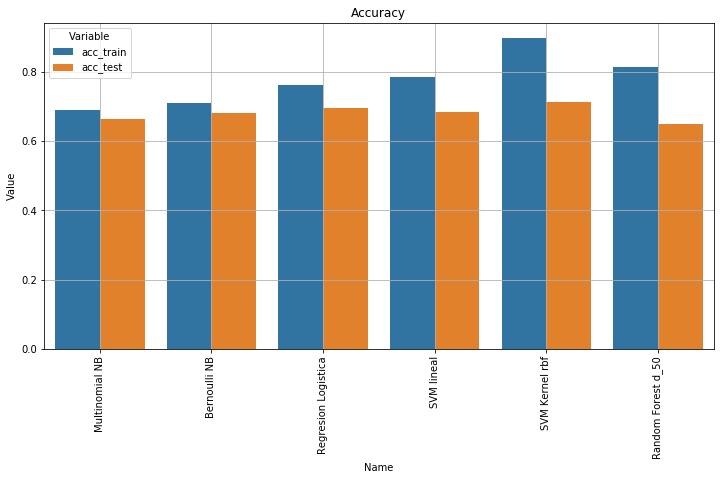

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Transformamos el dataframe para pintar las gráficas con seaborn
df_plot = results[['acc_train', 'acc_test']].reset_index().melt(id_vars='name').rename(columns=str.title)

# Pintamos el gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x='Name', y='Value', hue='Variable', data=df_plot)
plt.title("Accuracy")
plt.grid()
plt.xticks(rotation=90)
plt.show()

<hr>


# Elección del modelo y exportación en "Pickle"


* El "mejor" modelo (a nivel de accuracy) es el creado por el algoritmo de aprendizaje del ***Support Vector Machine*** utilizando el kernel "***rbf***"; si bien es cierto que sobreajusta bastante a los datos de entrenamiento, obtiene bastantes buenos resultados con los datos de test.


* Dado que este ejercicio es una prueba de concepto no vamos a profundizar mucho en la elección del modelo y seleccionaremos el que mejor accuracy tenga.


##### NOTAS:
##### 1.- Esta elección del modelo se ha realizado con los tweets leidos en el momento de la ejecución. Es posible que si este proceso se ejecuta en otro momento con otros tweets, el mejor modelo puede ser otro.
##### 2.- Para la resolución de este problema se pueden utilizar otros algoritmos de aprendizaje o métodos ensemble que resuelvan problemas de clasificación. También este problema se puede mejorar estudiando los hiperparámetros que se le pasa a los Algoritmos de Aprendizaje.



## 1. Creacción del Modelo con todos los tweets


* Una vez que hemos seleccionado el Algoritmo de Aprendizaje (***Support Vector Machine***) que mejor modelos genera, vamos a crear un modelo utilizando todos los datos (tweets) disponibles en el dataset.


* Pasamos a crear el modelo con todos los datos:

In [10]:
from sklearn.svm import SVC

best_model = SVC(kernel='rbf')
best_model.fit(X_bow, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

* Obtenemos las métricas del modelo con los propios datos de entrenamiento

In [11]:
from sklearn.metrics import classification_report
labels = ['psoe', 'pp', 'vox', 'podemos', 'ciudadanos']
print(classification_report(y_true=y, y_pred=best_model.predict(X_bow), labels=labels))

              precision    recall  f1-score   support

        psoe       0.95      0.92      0.93      6123
          pp       0.91      0.89      0.90      4837
         vox       0.92      0.83      0.87      4722
     podemos       0.78      0.94      0.85      5055
  ciudadanos       0.96      0.90      0.93      4223

    accuracy                           0.90     24960
   macro avg       0.90      0.89      0.90     24960
weighted avg       0.90      0.90      0.90     24960



* Pintamos la matriz de confusión para hacernos una idea de como clasifica el modelo seleccionado.

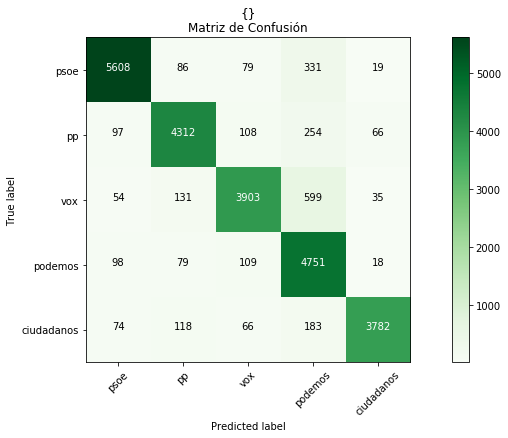

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

from sklearn.metrics import confusion_matrix

# Definimos el heatmap de la matriz de confusión
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Calculamos la matriz de confusión
cm = confusion_matrix(y_true=y, y_pred=best_model.predict(X_bow), labels=labels)   

# Pintamos la matriz de confusión
plt.figure(figsize=(12, 6))
plot_confusion_matrix(cm, classes=labels, title='{}\nMatriz de Confusión')

## 2. Exportación del Modelo Pickle


* Ahora vamos a exportar el modelo creado por el Algoritmo de Aprendizaje en formato pickle.


* El modelo creado se ha generado con una determinada ***bolsa de palabras*** que contenia 1000 Palabras en su diccionario. Por tanto tambien tenemos que exportar el modelo generado por el ***CountVectorizer*** para que los nuevos tweets a predecir se ajusten a esa BoW.


* Por tanto tenemos que realizar:
    1. Exportar el ***Modelo*** generado por el Algoritmo de Aprendizaje.
    2. Exportar la ***Bolsa de Palabras*** generado por la clase ***CountVectorizer***.
    
    
* Exportamos el modelo generado por el Algoritmo de Aprendizaje.

In [13]:
import pickle

filename = './models/best_model_tweets_politica.pickle'
save_model = open(filename,"wb")
pickle.dump(best_model, save_model) # con la función 'dump' guardamos el modelo
save_model.close()

* Exportar la ***Bolsa de Palabras*** generado por la clase ***CountVectorizer***.

In [14]:
filename = './models/vectorizer_bow_tweets_politica.pickle'
save_bow = open(filename,"wb")
pickle.dump(vectorizer, save_bow)
save_bow.close()

<hr>


# Bonus Track - Nubes de Palabras (WordCloud)


* Un punto interesante cuando trabajamos con la clasificación de textos subjetivos (Análisis de Sentimientos) es la de ver cuales son las palabras relevantes de cada una de las clases.


* Una representación trivial sería la de crear una gráfica de barras en la que mostrasemos la relación entre la palabra y su frecuencia (el número de veces que aparece). Este tipo de representación (gráfico de barras); cuando trabajamos con textos, no suele aportarnos una información demasiado descriptiva ya que hay pocas palabras dentro de una clase que se repiten muchas veces y otras que siendo relevantes y descriptivas de la clase aparecen 'n' veces menos que la palabra más relevante, por lo tanto tendríamos una gráfica de barras muy desbalanceada.


* Una buena representación para ver la relevancia de las palabras dentro de una clase son las "Nubes de Palabras" (Word Cloud) que son una representación visual de las palabras que conforman un texto, en donde el tamaño es mayor para las palabras que aparecen con más frecuencia.


* Con esta representación podemos ver cuales son las palabras más relevantes así como otras palabras que también son relevantes pero que tienen una menor frecuencia.


* Una de las librerías en python para realizar este tipo de tareas es "WordCloud": https://amueller.github.io/word_cloud/


* Veamos a continuación un sencillo ejemplo de nubes de palabras para todos los Tweets y por partido político.

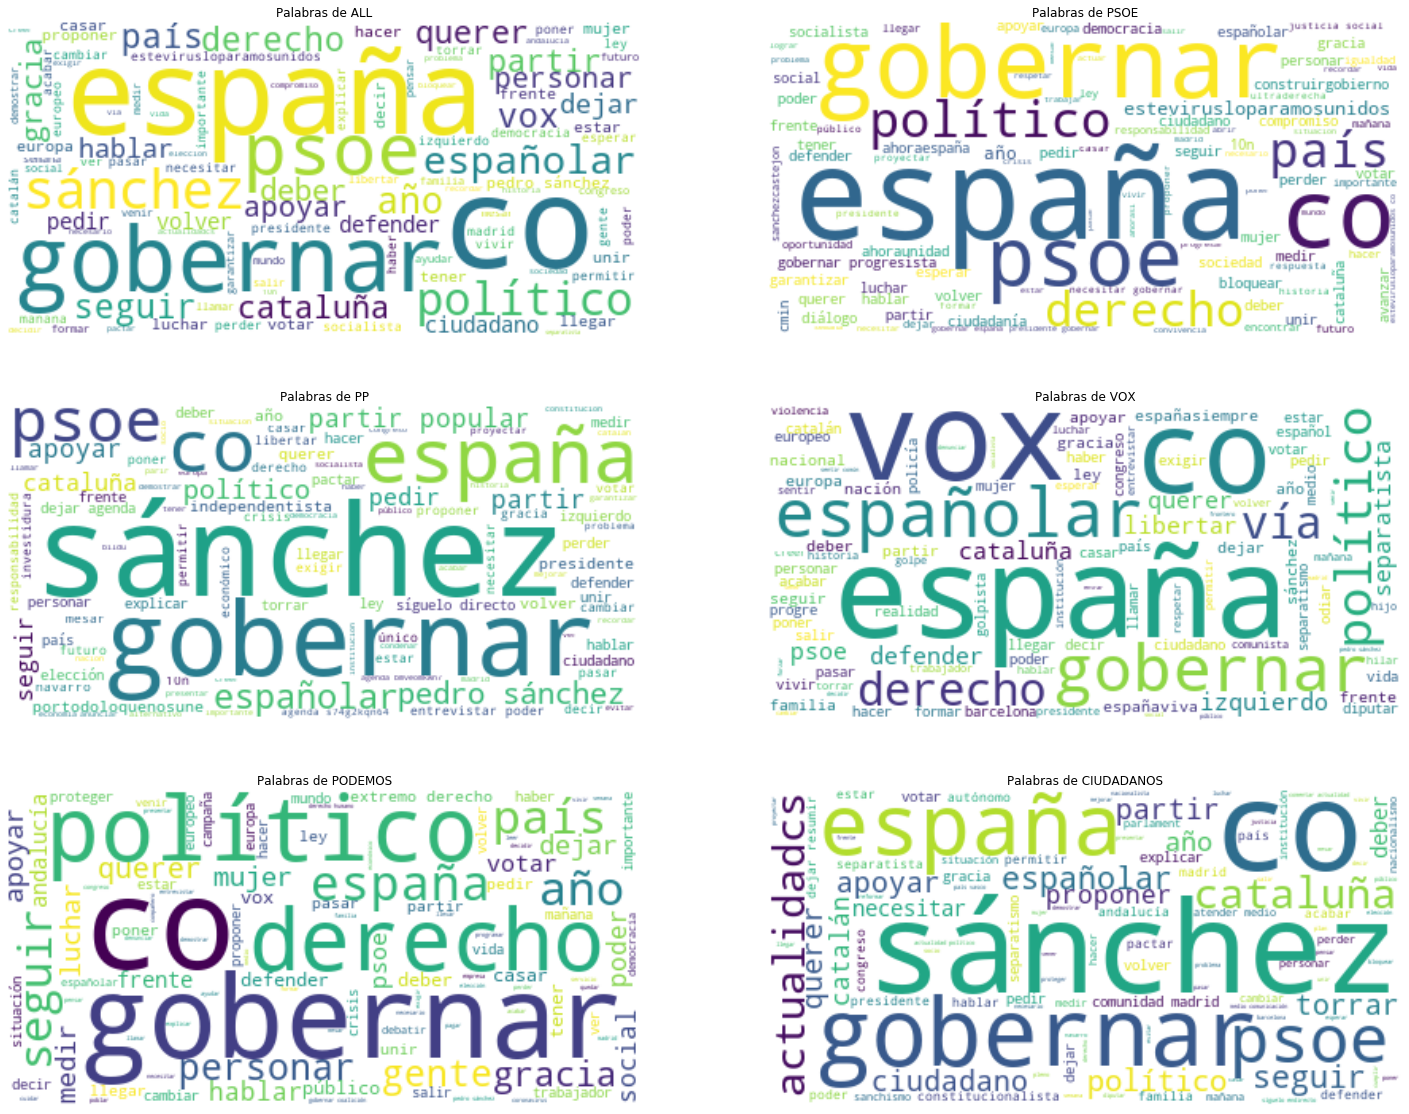

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools
%matplotlib inline


words_partidos = {
    'all': ' '.join([tweet for tweet in X_norm]),
    'psoe': ' '.join([X_norm[i] for i, x in enumerate(y) if x == "psoe"]),
    'pp': ' '.join([X_norm[i] for i, x in enumerate(y) if x == "pp"]),
    'vox': ' '.join([X_norm[i] for i, x in enumerate(y) if x == "vox"]),
    'podemos': ' '.join([X_norm[i] for i, x in enumerate(y) if x == "podemos"]),
    'ciudadanos': ' '.join([X_norm[i] for i, x in enumerate(y) if x == "ciudadanos"])
}

plt.figure(figsize=(25, 20))
pos = 1
for key, words in words_partidos.items():
    plt.subplot(3, 2, pos)
    wordcloud = WordCloud(max_font_size=80, max_words=100, background_color="white").generate(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Palabras de {}".format(key.upper()))
    pos += 1
plt.show()